# Oregon H-2A visas analysis


### Import Python analysis tools

In [1]:
import os
import pandas as pd
import geopandas as gp
from datetime import date
from shapely.geometry import Point

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_columns = None

In [4]:
%matplotlib inline

In [5]:
input_dir = os.path.join(os.getcwd(), 'input')
output_dir = os.path.join(os.getcwd(), 'output')

### Prepare the data for analysis

Download the source data files from the U.S. Department of Labor's [Office of Foreign Labor Certification](https://www.foreignlaborcert.doleta.gov/performancedata.cfm).

In [ ]:
%%capture
%run 01_download.ipynb

Prepare them for analysis by carefully combining annual lists, winnowing out duplicate entries and limiting the result to approved applications.

In [ ]:
%%capture
%run 02_transform.ipynb

Map work site locations

In [ ]:
%%capture
run 03_geocode.ipynb

### Finding: The total number of certified H2A visas has generally increased nationwide

Read in the transformed file for analysis

In [6]:
df = pd.read_csv(
    os.path.join(output_dir, "transformed_master_cases.csv"),
    index_col="new_id",
)

Group by calendar year and sum the total number of certified workers

In [7]:
annual_usa = df.groupby("certification_start_year").agg(dict(workers_certified="sum"))

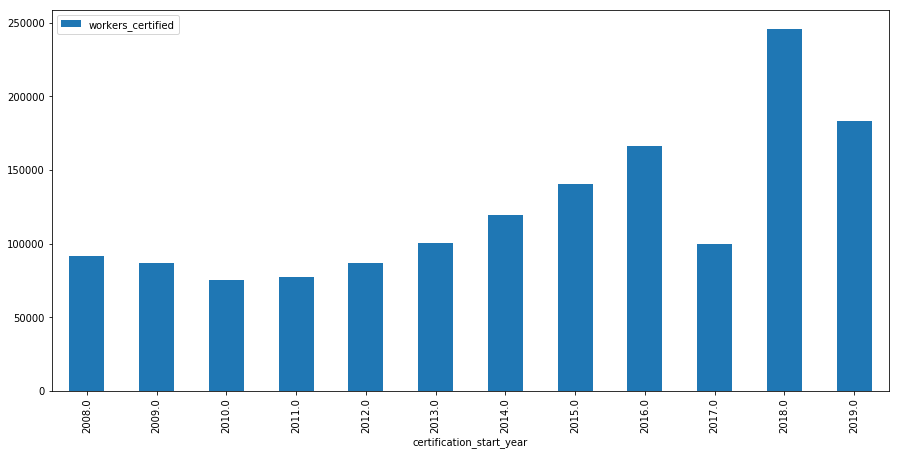

In [8]:
annual_usa.plot.bar(figsize=(15, 7))

In [9]:
annual_usa

,workers_certified
certification_start_year,
2008.0,91324
2009.0,86604
2010.0,75617
2011.0,77221
2012.0,86725
2013.0,100360
2014.0,119240
2015.0,140701
2016.0,166457


### Finding: Oregon's total topped 2,400 by the end of 2018, compared to less than 100 five years prior

Group the applications by state and year

In [10]:
state_totals = df.groupby([
    'state',
    'certification_start_year']
).agg(dict(workers_certified="sum"))

Create a crosstab for a graphic and comparison

In [11]:
state_crosstab = state_totals.unstack(1).fillna(0)

Output it for a graphic

In [12]:
state_crosstab.to_csv("./output/state_crosstab.csv")

Filter down to just Oregon's totals

In [13]:
or_totals = state_totals[state_totals.index.get_level_values(0) == 'OR']

Ouput the annual totals

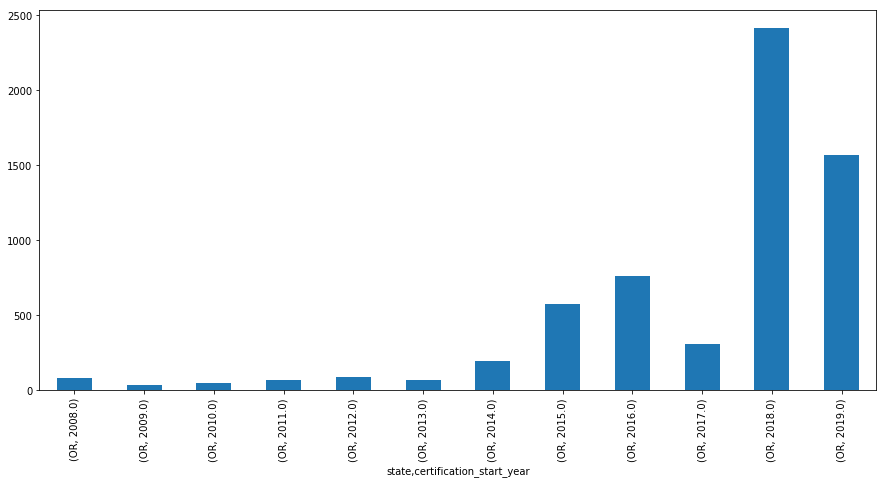

In [14]:
or_totals.workers_certified.plot.bar(figsize=(15, 7))

In [15]:
or_totals

workers_certified
state certification_start_year                   
OR    2008.0                                   81
      2009.0                                   39
      2010.0                                   48
      2011.0                                   68
      2012.0                                   89
      2013.0                                   70
      2014.0                                  199
      2015.0                                  573
      2016.0                                  762
      2017.0                                  307
      2018.0                                 2414
      2019.0                                 1568

Trim down to the last five years of data and calculate Oregon's percentage change

In [16]:
or_last_five = or_totals[
    (or_totals.index.get_level_values(1) > 2013) &
    (or_totals.index.get_level_values(1) < 2019)
].reset_index()

In [17]:
or_pct_change = or_last_five[[
  'certification_start_year',
  'workers_certified'
]].set_index('certification_start_year').pct_change(
    len(or_last_five)-1
)

In [18]:
print ("Percent change: %s%%" % round(or_pct_change.at[2018.0, 'workers_certified']*100, 2))

Percent change: 1113.07%


Output for a graphic

In [19]:
or_totals.reset_index()[['certification_start_year', 'workers_certified']].to_csv(
    "./output/oregon-totals-graphics.csv",
    index=False
)

### Finding: This year's hiring pace falls in line with last year's rate

Convert the start date column to a datetime object

In [20]:
df.certification_start_date = pd.to_datetime(df.certification_start_date)

Pull out the first four months of this year versus last year

In [21]:
first_four_19 = df[
    (df.state == 'OR') &
    (df.certification_start_date >= date(2019, 1, 1)) & 
    (df.certification_start_date < date(2019, 5, 1))
]

In [22]:
first_four_18 = df[
    (df.state == 'OR') &
    (df.certification_start_date >= date(2018, 1, 1)) & 
    (df.certification_start_date < date(2018, 5, 1))
]

Pull out the first 7 months of 2018 and 2019

In [ ]:
first_six_19 = df[
    (df) &
    (df.certification_start_date >= date(2019, 1, 1)) & 
    (df.certification_start_date < date(2019, 6, 1))
]

In [ ]:
first_seven_18 = df[
    (df) &
    (df.certification_start_date >= date(2018, 1, 1)) & 
    (df.certification_start_date < date(2018, 7, 1))
]

Compare the total hires in that period

In [23]:
first_four_18.workers_certified.sum()

747

In [24]:
first_four_19.workers_certified.sum()

723

### Finding: Counties along Oregon's I-5 corridor, from Jackson up to Clackamas, are driving the growth

Read in all "sub" cases rather than the master cases. This allows for the farms where workers are actually employed to be mapped, rather than the the "master cases" of middlemen who sometimes file the "master" applications. 

In [25]:
combined_df = pd.read_csv(os.path.join(output_dir, "geocoded_all_cases.csv"))

Convert to a geodataframe.

In [26]:
def create_point(row):
    if row.lng and row.lat:
        return Point(row.lng, row.lat)
    return ''

In [27]:
combined_df['geometry'] = combined_df.apply(create_point, axis=1)

In [28]:
gdf = gp.GeoDataFrame(combined_df)

In [29]:
gdf.crs = {'init' :'epsg:4269'}

Exclude cases that could not be mapped.

In [30]:
valid_gdf = gdf[~gdf.lat.isnull()]

Spatial join with county polygons

In [31]:
counties = gp.read_file(os.path.join(input_dir, "cb_2018_us_county_5m.shp"))

In [32]:
gdf_with_county = gp.sjoin(counties, valid_gdf, how="inner")

Filter to Oregon

In [33]:
or_gdf = gdf_with_county[gdf_with_county.STATEFP == '41']

Create a crosstab of the total number of workers by year in all Oregon counties

In [34]:
county_crosstab = or_gdf.groupby([
    'NAME',
    'certification_start_year'
]).net_workers.sum().reset_index().set_index([
    "NAME",
    "certification_start_year"
]).unstack(1).fillna(0)

Strip all the pandas chrome off the crosstab

In [35]:
county_crosstab = county_crosstab.reset_index()
county_crosstab.columns = county_crosstab.columns.droplevel(0)
county_crosstab = county_crosstab.rename_axis(None, axis=1)
county_crosstab = county_crosstab.set_index("")

Calculate the change in each county

In [36]:
county_crosstab['change_13to18'] = county_crosstab.apply(
    lambda x: x[2018.0] - x[2013.0],
    axis=1
)

Rank them by their change

In [37]:
county_crosstab.sort_values("change_13to18", ascending=False).head(10)

,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,change_13to18
,,,,,,,,,,,,,
Clackamas,0.0,2.0,0.0,1.0,25.0,10.0,29.0,74.0,54.0,56.0,578.0,321.0,568.0
Jackson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,177.0,0.0,408.0,116.0,408.0
Hood River,0.0,0.0,0.0,0.0,0.0,0.0,40.0,54.0,81.0,12.0,223.0,118.0,223.0
Umatilla,15.0,9.0,4.0,12.0,15.0,0.0,58.0,286.0,43.0,5.0,132.0,22.0,132.0
Wasco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,72.0,54.0,131.0,148.0,131.0
Polk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,88.0,90.0,0.0,90.0
Jefferson,6.0,9.0,16.0,17.0,3.0,7.0,15.0,0.0,49.0,46.0,86.0,57.0,79.0
Marion,3.0,3.0,3.0,7.0,9.0,3.0,3.0,0.0,38.0,18.0,53.0,142.0,50.0
Malheur,6.0,4.0,8.0,2.0,3.0,3.0,2.0,1.0,2.0,8.0,42.0,45.0,39.0


Output that for a graphic

In [38]:
county_crosstab.to_csv(os.path.join(output_dir, "county-crosstab.csv"), encoding="utf-8")

Total up the workers by city for a map

In [39]:
or_location_totals = or_gdf.groupby([
    "certification_start_year",
    "geocoder_address",
    "lat",
    'lng',
]).net_workers.sum().reset_index()

In [40]:
or_location_totals['certification_start_year'] = or_location_totals.certification_start_year.astype(int)

In [41]:
or_location_totals['net_workers'] = or_location_totals.net_workers.astype(int)

In [42]:
or_location_totals.columns = [
    'year',
    'address',
    'lat',
    'lng',
    'workers'
]

Output that for a graphic

In [43]:
or_location_totals.to_csv(os.path.join(output_dir, "or_totals_by_location.csv"), index=False)

### Finding: General Farm Laborers and strawberry farmworkers have accounted for most of the new workers in Oregon

Regroup subcases in the state by our cleaned up version of the crop column

In [44]:
or_crops = or_gdf.groupby([
    "certification_start_year",
    "oregon_crop"
]).net_workers.sum().reset_index().sort_values("net_workers", ascending=False)

Create a crosstab by year

In [45]:
crops_crosstab = or_crops.set_index([
    "certification_start_year",
    "oregon_crop"
]).unstack(0).fillna(0)

Again, strip the pandas chrome from the crosstab

In [46]:
crops_crosstab = crops_crosstab.reset_index()
crops_crosstab.columns = crops_crosstab.columns.droplevel(0)
crops_crosstab = crops_crosstab.rename_axis(None, axis=1)
crops_crosstab = crops_crosstab.set_index("")

Calculate the change over the past five years

In [47]:
crops_crosstab['change_14to19'] = crops_crosstab.apply(
    lambda x: x[2019.0] - x[2014.0],
    axis=1
)

Rank the crops

In [48]:
crops_crosstab.sort_values("change_14to19", ascending=False).head(10)

,2010.0,2011.0,2012.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,change_14to19
,,,,,,,,,,
Strawberries,0.0,0.0,0.0,0.0,0.0,151.0,16.0,52.0,294.0,294.0
General Farm Workers,0.0,0.0,0.0,0.0,0.0,0.0,58.0,521.0,250.0,250.0
Cherries,0.0,0.0,0.0,0.0,0.0,59.0,27.0,139.0,125.0,125.0
Pears,0.0,0.0,0.0,0.0,0.0,250.0,0.0,192.0,116.0,116.0
Radishes,0.0,0.0,0.0,0.0,0.0,27.0,0.0,78.0,99.0,99.0
Onions,0.0,0.0,0.0,0.0,0.0,45.0,8.0,130.0,42.0,42.0
Christmas Trees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,32.0
Sheep,9.0,40.0,15.0,7.0,5.0,32.0,19.0,37.0,26.0,19.0
Watermelons,0.0,0.0,0.0,0.0,0.0,22.0,0.0,30.0,15.0,15.0


Ouput for a graphic

In [49]:
crops_crosstab.to_csv(os.path.join(output_dir, "crops-crosstab.csv"))

### Looking at Malheur County, OR

Filter down to subcases in this one county

In [50]:
malheur = gdf_with_county[gdf_with_county.NAME.isin(['Nyssa', 'Ontario', 'Westfall', 'Juntura'])]

Count the total number of workers there by year

In [51]:
malheur_crosstab = malheur.groupby([
    'certification_start_year'
]).net_workers.sum().reset_index().set_index("certification_start_year")

Ouput the totals

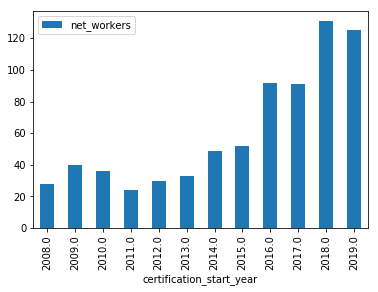

In [52]:
malheur_crosstab.plot.bar()

In [53]:
malheur_crosstab

,net_workers
certification_start_year,
2008.0,28.0
2009.0,40.0
2010.0,36.0
2011.0,24.0
2012.0,30.0
2013.0,33.0
2014.0,49.0
2015.0,52.0
2016.0,92.0


Look at the crop for those 2019 workers

In [54]:
malheur[malheur.certification_start_year == 2019][[
    'case_number',
    'employer',
    'city',
    'job_title',
    'crop',
    'net_workers'
]]

,case_number,employer,city,job_title,crop,net_workers
2707,H-300-19023-276039,"HANSEN FARMS, LLC",Stanley,Farm Worker,Nursery and Greenhouse Workers,48.0
2707,H-300-18339-675666,"Red Jacket Orchards, Inc.",Geneva,Farmworker,Rhubarb,20.0
2707,H-300-18324-205895,Lucas Vineyards,Geneva,Vineyard Worker,Vineyards,2.0
2707,H-300-18324-205895,Wagner Farms,Geneva,Vineyard Worker,Vineyards,4.0
2707,H-300-18324-205895,Wagner Vineyards LLC,Geneva,Vineyard Worker,Vineyards,5.0
2707,H-300-18324-571275,Forking Paths Vineyards Inc. and Associates,Geneva,Vineyard Worker,Vineyards,10.0
2707,H-300-18324-205895,Forking Paths Vineyards Inc. and Associates,Geneva,Vineyard Worker,Vineyards,8.0
2707,H-300-19060-759274,"Pedersen Farms, Inc.",Seneca Castle,Farmworker,General Farm Workers,28.0


### Finding: Grains workers account for most of the growth in that area

In [55]:
malheur_crops = malheur[malheur.certification_start_year == 2018].groupby([
    'oregon_crop'
]).net_workers.sum().reset_index().set_index("oregon_crop")

In [56]:
malheur_crops.sort_values("net_workers", ascending=False).head(10)

,net_workers
oregon_crop,
Grains,41.0
Grapes,29.0
Herbs,26.0
Berries,20.0
General Farm Workers,15.0
